### SELECTING PUBLIC PARK BUILD SITE IN THE CITY OF SYRACUSE, NY

#### Introduction

![image.png](Park-PNG-Transparent-Background.png)


>CITY PARKS PLAY A VITAL ROLE IN THE SOCIAL, ECONOMIC, AND PHYSICAL WELL-BEING OF AMERICA’S CITIES AND THEIR RESIDENTS. BUILDING A COMMUNITY PARK IS A TIME INTENSIVE AND COSTLY PROCESS; IT IS THEREFORE IMPORTANT TO SELECT THE PROPER LOCATION TO ENSURE ITS USE AND POSITIVE IMPACT ARE MAXIMIZED.  THE PURPOSE OF THIS ANALYSIS IS IDENTIFY NEIGHBORHOODS IN THE CITY OF SYRACUSE, NY THAT ARE:
    1. CURRENTLY UNDERSERVED FROM A PUBLIC PARK PERSPECTIVE
    2. RESIDENTIALLY DENSE ENOUGH TO MINIMIZE TRAVEL TIME FOR USERS (AVOIDING PRIMARILY INDUSTRIAL AND COMMERCIAL AREAS) AND WITH A SIGNIFICANT POPULATION OF CHILDREN

>THE TARGET AUDIENCE RECEIVING THIS ANALYSIS WOULD BE LOCAL POLITICIANS OR COMMUNITY BOARDS THAT COULD FACILITATE THE FUNDING AND SUPPORT FOR THE PROPOSED PARK.

#### Data

>SYRACUSE NEIGHBORHOODS WILL BE DEFINED USING A GEOJSON FILE FROM THE U.S. CENSUS BUREAU TO INCLUDE THOSE TRACTS IN THE GREATER SYRACUSE METROPOLITAN AREA WITHIN ONONDAGA COUNTY, NY. THE CENTROIDS OF THESE NEIGHBORHOODS WILL BE USED TO OBTAIN VENUE DATA VIA A FOURSQUARE API CALL. ADDITIONALLY, A SEPARATE US CENSUS BUREAU FILE WILL BE USED TO IDENTIFY CHILDRED AGED 0-14. A K-MEANS CLUSTERING ALGORITHM WILL BE USED TO IDENTIFY NEIGHBORHOODS THAT ARE SIMILAR TO CURRENT PARK SITES, BUT WITHOUT A PARK VENUE, AND WITH A SIGNIFICANT YOUTH POPULATION THAT WOULD GREATLY BENEFIT FROM THE ADDITION OF A PUBLIC PARK.

In [1]:
import pandas as pd
import folium # map rendering library
import os
import pathlib as pl
import json
pd.set_option('display.max_columns', 250)


latitude = 43.088947
longitude = -76.154480
county_path = os.path.join(pl.Path.cwd(),'cuse.geojson') 
county_geojson = json.load(open(county_path))
demos_path = os.path.join(pl.Path.cwd(),'metadata.json') 
demo_json = json.load(open(demos_path))

In [2]:
cuse_map = folium.Map(location=[latitude, longitude], zoom_start=12)
# add markers to map
folium.GeoJson(
    county_geojson,
    name='geojson'
).add_to(cuse_map)
folium.LayerControl().add_to(cuse_map)
cuse_map.save("./mymap.html")

cuse_map

In [3]:
lst = []
for i in range(len(county_geojson['features'])):
    lst.append([county_geojson['features'][i]['properties']['NAMELSAD10'],
                county_geojson['features'][i]['properties']['INTPTLAT10'],
                county_geojson['features'][i]['properties']['INTPTLON10'],
                ])
                

In [4]:
df = pd.DataFrame.from_records(lst, columns = ["Neighborhood", "Lat", "Long"])

In [5]:
for Name, Lat, Long, in \
 zip(df['Neighborhood'], df['Lat'], df['Long']):
 
 label = '{}'.format(Name)
 label = folium.Popup(label, parse_html=True)
 folium.CircleMarker(
 [Lat, Long],
 radius=5,
 popup=label,
 color='blue',
 fill=True,
 fill_color='#3186cc',
 fill_opacity=0.7,
 parse_html=False).add_to(cuse_map)

In [6]:
cuse_map

In [7]:
neighborhood_latitude = df.loc[0, 'Lat'] # neighborhood latitude value
neighborhood_longitude = df.loc[0, 'Long'] # neighborhood longitude value

neighborhood_name = df.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Census Tract 43.02 are +43.0400403, -076.1346433.


In [8]:
CLIENT_ID = 'JBREGZ4UNA53HX43WMAD4TQ2X2XJWMX5DPHEZEIZHQA0ACNP' # your Foursquare ID
CLIENT_SECRET = 'VNS40KF3V4MGSWWAV0IGQINZIGIT1EQKNCWBFPOS3QF1JMOJ' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version


In [9]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 2000 # define radius
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=JBREGZ4UNA53HX43WMAD4TQ2X2XJWMX5DPHEZEIZHQA0ACNP&client_secret=VNS40KF3V4MGSWWAV0IGQINZIGIT1EQKNCWBFPOS3QF1JMOJ&v=20180605&ll=+43.0400403,-076.1346433&radius=2000&limit=100'

In [10]:
import requests
results = requests.get(url).json()

In [11]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [12]:
import json 
from pandas.io.json import json_normalize
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head(10)

,name,categories,lat,lng
0,Varsity Pizza,Pizza Place,43.041515,-76.136690
1,Insomnia Cookies,Dessert Shop,43.041635,-76.135704
2,Faegan's Cafe & Pub,Pub,43.041802,-76.136610
3,Manny's,Clothing Store,43.041652,-76.135343
4,Unique Tea House,Tea Room,43.041750,-76.134854
5,SU Cafe,Coffee Shop,43.042980,-76.131670
6,Bleu Monkey Cafe,Sushi Restaurant,43.041687,-76.135166
7,Chipotle Mexican Grill,Mexican Restaurant,43.041834,-76.135854
8,Goldstein Auditorium,College Theater,43.039887,-76.133697
9,Club 44,Lounge,43.036169,-76.136924


In [84]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [85]:
cuse_venues = getNearbyVenues(names=df['Neighborhood'],
                                   latitudes=df['Lat'],
                                   longitudes=df['Long']
                                  )

Census Tract 43.02
Census Tract 43.01
Census Tract 21.01
Census Tract 5.01
Census Tract 29.01
Census Tract 2
Census Tract 3
Census Tract 4
Census Tract 6
Census Tract 7
Census Tract 8
Census Tract 9
Census Tract 10
Census Tract 14
Census Tract 15
Census Tract 16
Census Tract 17.01
Census Tract 17.02
Census Tract 18
Census Tract 19
Census Tract 20
Census Tract 23
Census Tract 24
Census Tract 27
Census Tract 30
Census Tract 32
Census Tract 34
Census Tract 35
Census Tract 36.01
Census Tract 36.02
Census Tract 38
Census Tract 39
Census Tract 40
Census Tract 42
Census Tract 44
Census Tract 45
Census Tract 46
Census Tract 48
Census Tract 49
Census Tract 50
Census Tract 51
Census Tract 52
Census Tract 53
Census Tract 54
Census Tract 55
Census Tract 56.01
Census Tract 56.02
Census Tract 57
Census Tract 58
Census Tract 59
Census Tract 60
Census Tract 61.01
Census Tract 61.02
Census Tract 61.03
Census Tract 1


In [86]:
print(cuse_venues.shape)
cuse_venues.tail()

(518, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
513,Census Tract 1,+43.0691355,-076.1730170,Auntie Anne's,43.070534,-76.172636,Snack Place
514,Census Tract 1,+43.0691355,-076.1730170,Yankee Candle Company,43.069896,-76.172817,Gift Shop
515,Census Tract 1,+43.0691355,-076.1730170,Vans Off The Wall,43.069176,-76.172730,Shoe Store
516,Census Tract 1,+43.0691355,-076.1730170,At Home,43.068464,-76.174303,Furniture / Home Store
517,Census Tract 1,+43.0691355,-076.1730170,Macy's,43.071452,-76.172424,Department Store


In [87]:
cuse_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Census Tract 1,49,49,49,49,49,49
Census Tract 10,13,13,13,13,13,13
Census Tract 14,10,10,10,10,10,10
Census Tract 15,8,8,8,8,8,8
Census Tract 16,4,4,4,4,4,4
Census Tract 17.01,4,4,4,4,4,4
Census Tract 17.02,6,6,6,6,6,6
Census Tract 18,4,4,4,4,4,4
Census Tract 19,6,6,6,6,6,6


In [88]:
print('There are {} uniques categories.'.format(len(cuse_venues['Venue Category'].unique())))

There are 160 uniques categories.


In [89]:
cuse_onehot = pd.get_dummies(cuse_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
cuse_onehot['Neighborhood'] = cuse_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [cuse_onehot.columns[-1]] + list(cuse_onehot.columns[:-1])
cuse_onehot = cuse_onehot[fixed_columns]

cuse_onehot.head()

,Neighborhood,Accessories Store,Adult Boutique,American Restaurant,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Athletics & Sports,BBQ Joint,Bakery,Bank,Bar,Baseball Field,Basketball Stadium,Beer Bar,Beer Garden,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Bus Station,Bus Stop,Business Service,Café,Candy Store,Caribbean Restaurant,Chinese Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,College Academic Building,College Hockey Rink,College Rec Center,College Residence Hall,College Theater,Comedy Club,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Discount Store,Dive Bar,Dive Shop,Dog Run,Donut Shop,Drugstore,Eastern European Restaurant,Electronics Store,Exhibit,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Flower Shop,Fondue Restaurant,Food,Food Truck,Football Stadium,Furniture / Home Store,Garden,Gastropub,Gay Bar,General Entertainment,Gift Shop,Golf Course,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Halal Restaurant,Health & Beauty Service,Herbs & Spices Store,History Museum,Hobby Shop,Home Service,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jewelry Store,Korean Restaurant,Lawyer,Lingerie Store,Liquor Store,Lounge,Massage Studio,Mattress Store,Mexican Restaurant,Middle Eastern Restaurant,Motel,Motorcycle Shop,Movie Theater,Music Store,Music Venue,Nail Salon,New American Restaurant,Noodle House,Optical Shop,Other Nightlife,Other Repair Shop,Park,Pharmacy,Pizza Place,Playground,Plaza,Pool,Pool Hall,Print Shop,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Rental Service,Rest Area,Restaurant,Rock Climbing Spot,Salon / Barbershop,Sandwich Place,Scenic Lookout,Science Museum,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skating Rink,Smoke Shop,Snack Place,Souvenir Shop,Sporting Goods Shop,Sports Bar,Student Center,Supermarket,Sushi Restaurant,Tea Room,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Thrift / Vintage Store,Tourist Information Center,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Wings Joint,Yoga Studio,Zoo
0,Census Tract 43.02,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Census Tract 43.02,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Census Tract 43.02,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Census Tract 43.02,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Census Tract 43.02,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [90]:
cuse_grouped = cuse_onehot.groupby('Neighborhood').mean().reset_index()
cuse_grouped

,Neighborhood,Accessories Store,Adult Boutique,American Restaurant,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Athletics & Sports,BBQ Joint,Bakery,Bank,Bar,Baseball Field,Basketball Stadium,Beer Bar,Beer Garden,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Bus Station,Bus Stop,Business Service,Café,Candy Store,Caribbean Restaurant,Chinese Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,College Academic Building,College Hockey Rink,College Rec Center,College Residence Hall,College Theater,Comedy Club,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Discount Store,Dive Bar,Dive Shop,Dog Run,Donut Shop,Drugstore,Eastern European Restaurant,Electronics Store,Exhibit,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Flower Shop,Fondue Restaurant,Food,Food Truck,Football Stadium,Furniture / Home Store,Garden,Gastropub,Gay Bar,General Entertainment,Gift Shop,Golf Course,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Halal Restaurant,Health & Beauty Service,Herbs & Spices Store,History Museum,Hobby Shop,Home Service,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jewelry Store,Korean Restaurant,Lawyer,Lingerie Store,Liquor Store,Lounge,Massage Studio,Mattress Store,Mexican Restaurant,Middle Eastern Restaurant,Motel,Motorcycle Shop,Movie Theater,Music Store,Music Venue,Nail Salon,New American Restaurant,Noodle House,Optical Shop,Other Nightlife,Other Repair Shop,Park,Pharmacy,Pizza Place,Playground,Plaza,Pool,Pool Hall,Print Shop,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Rental Service,Rest Area,Restaurant,Rock Climbing Spot,Salon / Barbershop,Sandwich Place,Scenic Lookout,Science Museum,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skating Rink,Smoke Shop,Snack Place,Souvenir Shop,Sporting Goods Shop,Sports Bar,Student Center,Supermarket,Sushi Restaurant,Tea Room,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Thrift / Vintage Store,Tourist Information Center,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Wings Joint,Yoga Studio,Zoo
0,Census Tract 1,0.020408,0.0,0.020408,0.020408,0.000000,0.000000,0.000000,0.0,0.000000,0.040816,0.000000,0.020408,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.020408,0.000000,0.020408,0.020408,0.020408,0.000000,0.0,0.00,0.020408,0.020408,0.000000,0.020408,0.122449,0.000000,0.020408,0.000000,0.000,0.0,0.000000,0.000000,0.020408,0.000000,0.000000,0.000000,0.061224,0.000000,0.000000,0.040816,0.000000,0.020408,0.000000,0.000000,0.0000,0.000000,0.00,0.00,0.020408,0.000000,0.000000,0.000000,0.000000,0.000000,0.020408,0.000000,0.000000,0.0,0.020408,0.000000,0.000000,0.000,0.020408,0.020408,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00,0.0,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.00,0.040816,0.000000,0.000000,0.000000,0.000000,0.000000,0.020408,0.0000,0.0000,0.000000,0.040816,0.00,0.000000,0.000000,0.00,0.020408,0.000000,0.000000,0.000,0.020408,0.000000,0.000000,0.020408,0.00000,0.000000,0.020408,0.000000,0.00,0.000000,0.000000,0.000000,0.0,0.00000,0.000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000,0.000000,0.000000,0.000000,0.00000,0.00,0.020408,0.020408,0.0,0.000000,0.000000,0.040816,0.000000,0.020408,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.020408,0.040816,0.000000,0.00,0.000000,0.000000,0.000000,0.000,0.000000,0.000000
1,Census Tract 10,0.000000,0.0,0.076923,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.076923,0.000000,0.000000,0.000000,0.000000,0.153846,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.076923,0.

In [91]:
num_top_venues = 5

for hood in cuse_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = cuse_grouped[cuse_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Census Tract 1----
                          venue  freq
0                Clothing Store  0.12
1                Cosmetics Shop  0.06
2  Theme Park Ride / Attraction  0.04
3                Lingerie Store  0.04
4                Ice Cream Shop  0.04


----Census Tract 10----
                 venue  freq
0            Bookstore  0.15
1          Pizza Place  0.15
2       Cosmetics Shop  0.08
3  American Restaurant  0.08
4        Deli / Bodega  0.08


----Census Tract 14----
                  venue  freq
0        Discount Store   0.2
1         Deli / Bodega   0.1
2           Wings Joint   0.1
3              Pharmacy   0.1
4  Fast Food Restaurant   0.1


----Census Tract 15----
               venue  freq
0      Deli / Bodega  0.25
1  Convenience Store  0.12
2               Bank  0.12
3          Gastropub  0.12
4     Sandwich Place  0.12


----Census Tract 16----
            venue  freq
0          Hostel  0.25
1  History Museum  0.25
2   Grocery Store  0.25
3            Bank  0.25
4    Nood

                  venue  freq
0           Bus Station  0.25
1  Fast Food Restaurant  0.12
2           Music Venue  0.12
3   College Hockey Rink  0.12
4                   Gym  0.12


----Census Tract 57----
               venue  freq
0                Bar  0.17
1               Park  0.17
2  Convenience Store  0.17
3        Flower Shop  0.17
4               Food  0.17


----Census Tract 59----
                     venue  freq
0               Hobby Shop  0.25
1     Fast Food Restaurant  0.25
2   Furniture / Home Store  0.25
3           Discount Store  0.25
4  New American Restaurant  0.00


----Census Tract 6----
                   venue  freq
0              Drugstore  0.25
1      Convenience Store  0.25
2  Vietnamese Restaurant  0.25
3            Supermarket  0.25
4      Accessories Store  0.00


----Census Tract 60----
                venue  freq
0  Mexican Restaurant  0.25
1            Pharmacy  0.25
2      Sandwich Place  0.25
3             Dog Run  0.25
4         Pizza Place  0.00


-

In [92]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [108]:
import numpy as np
indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = cuse_grouped['Neighborhood']

for ind in np.arange(cuse_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(cuse_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Census Tract 1,Clothing Store,Cosmetics Shop,Bakery,Department Store,Ice Cream Shop
1,Census Tract 10,Pizza Place,Bookstore,Deli / Bodega,Pharmacy,Sandwich Place
2,Census Tract 14,Discount Store,Bakery,Gourmet Shop,Food,Italian Restaurant
3,Census Tract 15,Deli / Bodega,Gastropub,Wings Joint,Convenience Store,Sandwich Place
4,Census Tract 16,History Museum,Hostel,Grocery Store,Bank,Dive Bar


In [106]:
from sklearn.cluster import KMeans
# set number of clusters
kclusters = 4

cuse_grouped_clustering = cuse_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(cuse_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 1, 1, 1, 1, 0, 1, 1, 1, 1], dtype=int32)

For n_clusters = 2 The average silhouette_score is : 0.349507370368685
For n_clusters = 3 The average silhouette_score is : 0.15508788654164082
For n_clusters = 4 The average silhouette_score is : 0.13795680586330575
For n_clusters = 5 The average silhouette_score is : 0.10901238731558617
For n_clusters = 6 The average silhouette_score is : 0.06544275678689145


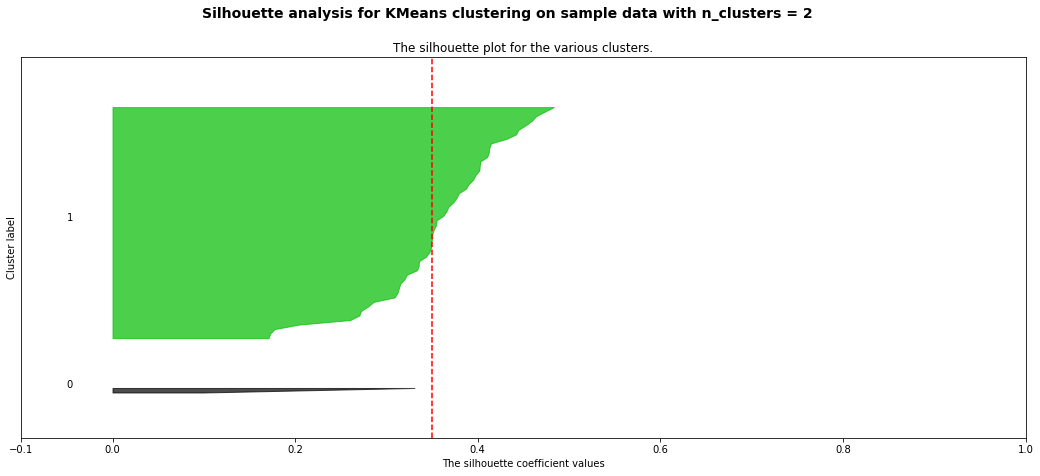

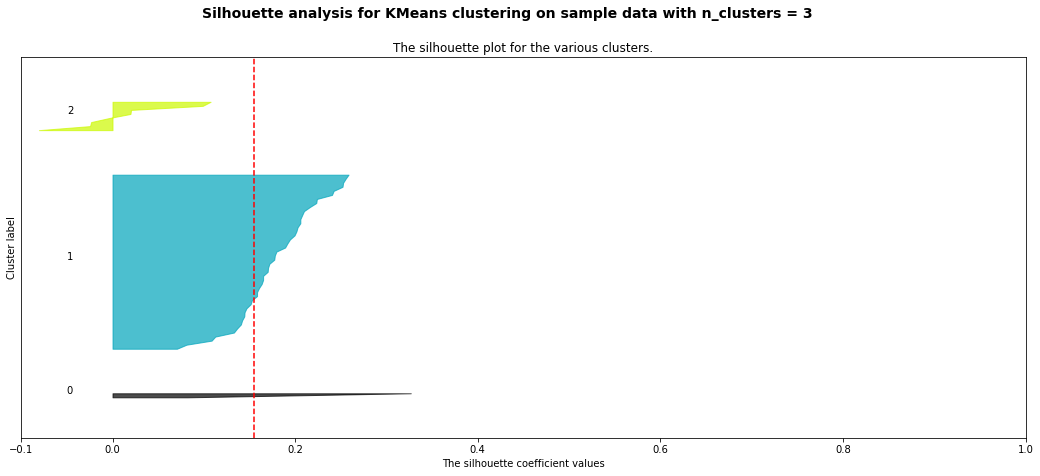

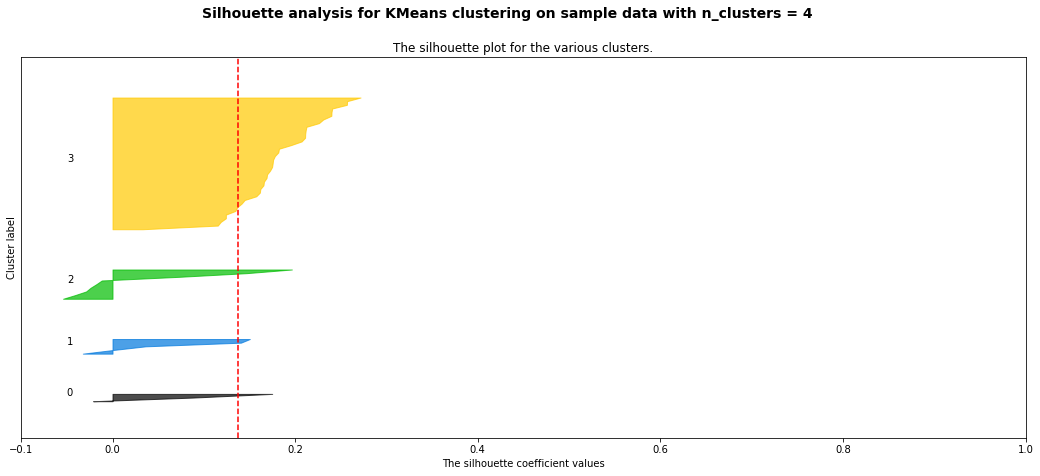

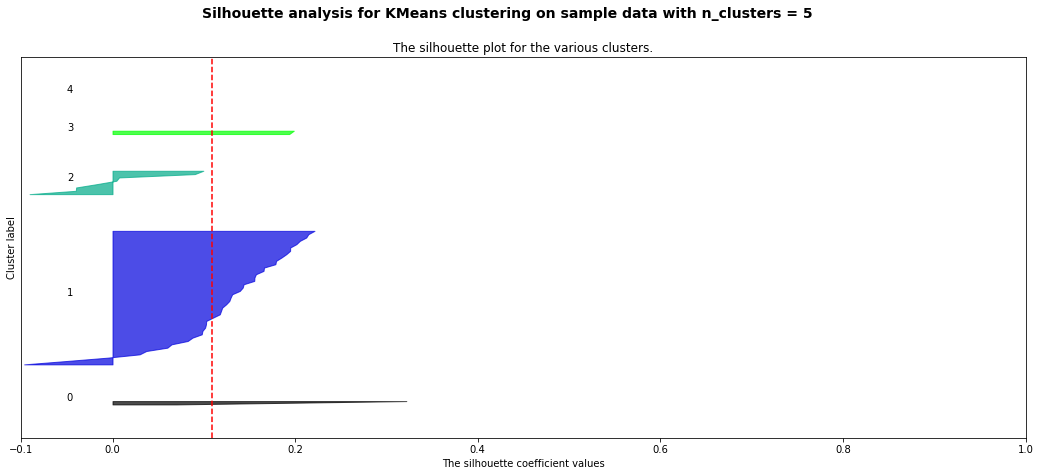

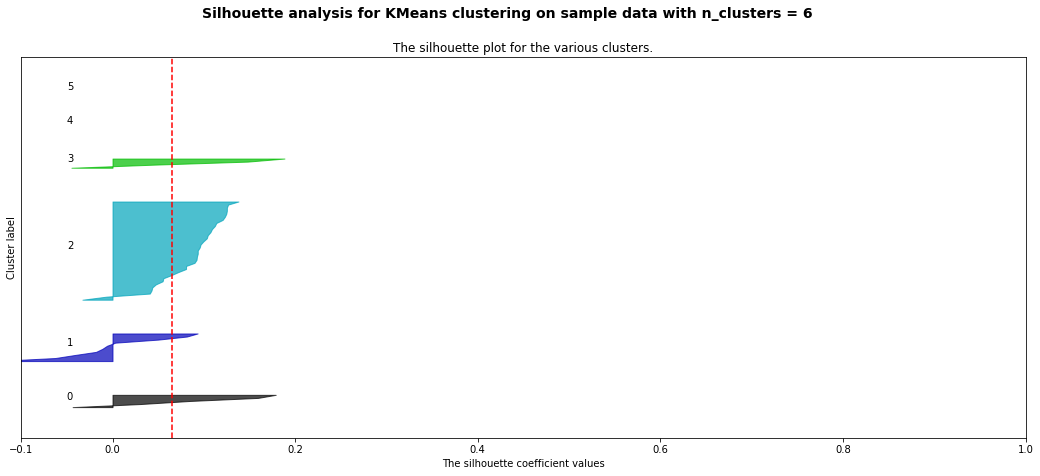

In [97]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.metrics import silhouette_samples, silhouette_score
range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1) = plt.subplots(1, 1)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(cuse_grouped_clustering) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(cuse_grouped_clustering)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(cuse_grouped_clustering, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(cuse_grouped_clustering, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

In [109]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

cuse_merged = df

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
cuse_merged = cuse_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')



# check the last columns!
cuse_merged.head()

,Neighborhood,Lat,Long,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Census Tract 43.02,+43.0400403,-076.1346433,1.0,Sandwich Place,Coffee Shop,Pizza Place,Sushi Restaurant,Bar
1,Census Tract 43.01,+43.0388643,-076.1400148,1.0,Sandwich Place,Coffee Shop,Pizza Place,Pharmacy,Donut Shop
2,Census Tract 21.01,+43.0526383,-076.1712469,1.0,Donut Shop,Motorcycle Shop,Grocery Store,Discount Store,Gay Bar
3,Census Tract 5.01,+43.0637527,-076.1569900,1.0,Convenience Store,Bakery,Liquor Store,Smoke Shop,Candy Store
4,Census Tract 29.01,+43.0441999,-076.1820651,1.0,Zoo,Bar,Convenience Store,Park,Other Nightlife


In [110]:
cuse_merged['Cluster Labels'].fillna(0, inplace=True)

In [111]:
import matplotlib.cm as cm
import matplotlib.colors as colors
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add boundaries/markers to the map
folium.GeoJson(
    county_geojson,
    name='geojson'
).add_to(map_clusters)

markers_colors = []
for lat, lon, poi, cluster in zip(cuse_merged['Lat'], cuse_merged['Long'], cuse_merged['Neighborhood'], cuse_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster-1)],
        fill=True,
        fill_color=rainbow[int(cluster-1)],
        fill_opacity=0.7).add_to(map_clusters)

#folium.LayerControl().add_to(map_clusters)    
map_clusters.save("./clustermap.html")
map_clusters


In [112]:
cuse_merged.loc[cuse_merged['Cluster Labels'] == 0, cuse_merged.columns[[4] + list(range(5, cuse_merged.shape[1]))]]

,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
11,Pool Hall,Park,Zoo,Discount Store,Electronics Store
16,Flower Shop,Convenience Store,Park,Eastern European Restaurant,Zoo
34,Garden,Gym / Fitness Center,Park,Theater,Zoo
39,Park,Gym / Fitness Center,Deli / Bodega,Scenic Lookout,Music Venue
40,Concert Hall,Park,Discount Store,Convenience Store,Dive Shop
44,Bakery,Park,Dive Bar,Exhibit,Electronics Store
48,NaN,NaN,NaN,NaN,NaN
53,Plaza,Park,Convenience Store,Scenic Lookout,Clothing Store


In [113]:
cuse_merged.loc[cuse_merged['Cluster Labels'] == 1, cuse_merged.columns[[4] + list(range(5, cuse_merged.shape[1]))]]

,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Sandwich Place,Coffee Shop,Pizza Place,Sushi Restaurant,Bar
1,Sandwich Place,Coffee Shop,Pizza Place,Pharmacy,Donut Shop
2,Donut Shop,Motorcycle Shop,Grocery Store,Discount Store,Gay Bar
3,Convenience Store,Bakery,Liquor Store,Smoke Shop,Candy Store
4,Zoo,Bar,Convenience Store,Park,Other Nightlife
5,Herbs & Spices Store,Pizza Place,Convenience Store,Sports Bar,Donut Shop
6,Construction & Landscaping,Deli / Bodega,Business Service,Intersection,Dance Studio
7,Bar,Playground,Vietnamese Restaurant,Italian Restaurant,Zoo
8,Convenience Store,Vietnamese Restaurant,Drugstore,Supermarket,Zoo
10,Bar,Pool,Convenience Store,Deli / Bodega,Rock Climbing Spot


In [114]:
cuse_merged.loc[cuse_merged['Cluster Labels'] == 2, cuse_merged.columns[[4] + list(range(5, cuse_merged.shape[1]))]]

,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
9,Pizza Place,Convenience Store,Zoo,Dive Bar,Exhibit
31,Convenience Store,Zoo,Dive Shop,Farmers Market,Exhibit


In [115]:
cuse_merged.loc[cuse_merged['Cluster Labels'] == 3, cuse_merged.columns[[4] + list(range(5, cuse_merged.shape[1]))]]

,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
42,Food,Deli / Bodega,Zoo,Dive Shop,Exhibit


In [117]:
demo_df = pd.read_csv('acs2017_5yr_B01001_14000US36067005601.csv')
dic = {}
for item in demo_df.columns:
    if item in demo_json['tables']['B01001']['columns'].keys():
        dic[item] = demo_json['tables']['B01001']['columns'][item]['name']

demo_df.rename(columns = dic, inplace=True)
demo_df['name'] = [x.split(',')[0] for x in demo_df.loc[:,'name']]

In [118]:
demo_df

,geoid,name,Total:,"B01001001, Error",Male:,"B01001002, Error",Under 5 years,"B01001003, Error",5 to 9 years,"B01001004, Error",10 to 14 years,"B01001005, Error",15 to 17 years,"B01001006, Error",18 and 19 years,"B01001007, Error",20 years,"B01001008, Error",21 years,"B01001009, Error",22 to 24 years,"B01001010, Error",25 to 29 years,"B01001011, Error",30 to 34 years,"B01001012, Error",35 to 39 years,"B01001013, Error",40 to 44 years,"B01001014, Error",45 to 49 years,"B01001015, Error",50 to 54 years,"B01001016, Error",55 to 59 years,"B01001017, Error",60 and 61 years,"B01001018, Error",62 to 64 years,"B01001019, Error",65 and 66 years,"B01001020, Error",67 to 69 years,"B01001021, Error",70 to 74 years,"B01001022, Error",75 to 79 years,"B01001023, Error",80 to 84 years,"B01001024, Error",85 years and over,"B01001025, Error",Female:,"B01001026, Error",Under 5 years,"B01001027, Error",5 to 9 years,"B01001028, Error",10 to 14 years,"B01001029, Error",15 to 17 years,"B01001030, Error",18 and 19 years,"B01001031, Error",20 years,"B01001032, Error",21 years,"B01001033, Error",22 to 24 years,"B01001034, Error",25 to 29 years,"B01001035, Error",30 to 34 years,"B01001036, Error",35 to 39 years,"B01001037, Error",40 to 44 years,"B01001038, Error",45 to 49 years,"B01001039, Error",50 to 54 years,"B01001040, Error",55 to 59 years,"B01001041, Error",60 and 61 years,"B01001042, Error",62 to 64 years,"B01001043, Error",65 and 66 years,"B01001044, Error",67 to 69 years,"B01001045, Error",70 to 74 years,"B01001046, Error",75 to 79 years,"B01001047, Error",80 to 84 years,"B01001048, Error",85 years and over,"B01001049, Error"
0,01000US,United States,321004407,0,158018753,5582,10151822,3520,10431216,17420,10585293,17356,6442108,3426,4417530,4259,2398153,12475,2353533,11529,6799319,16557,11378442,5106,10877571,3842,10170543,17078,10073171,17797,10374280,3958,10865843,3483,10433027,13117,3909845,11185,5301749,12280,3286984,9157,4235432,10546,5335292,10830,3654544,8404,2433521,7860,2109535,8840,162985654,5587,9701693,3669,10013906,15302,10127818,15348,6147423,3592,4211989,5076,2258672,11955,2224827,10995,6467461,17441,11028476,3696,10759684,3320,10218866,18087,10193839,18236,10587316,3271,11263704,3231,11090433,16722,4207280,11907,5805186,12573,3644183,11670,4760304,11370,6241194,12928,4561022,11384,3438390,10733,4031988,11243
1,04000US36,New York,19798228,0,9604111,859,602196,494,582997,3377,592548,3286,370642,435,267235,756,145637,2269,141979,2395,420124,2897,747182,676,688128,611,618841,3738,601029,3781,649734,730,683825,600,646471,3712,243597,3153,322827,2964,197405,2326,249355,2434,316326,2624,219003,2373,153550,1810,143480,2046,10194117,860,574681,429,557988,4315,566957,4322,355295,420,261333,901,141197,2441,138484,2580,418126,3061,749986,546,697871,458,637219,4101,628419,4273,683033,437,728389,419,699149,3332,268220,2733,358538,2852,230668,2873,292832,2667,388928,2769,293882,2542,228588,2265,294334,2534
2,05000US36067,Onondaga County,467669,0,225685,101,13830,72,14245,516,14537,517,9408,52,7579,115,3497,342,3451,290,9573,391,16109,11,14484,43,13064,528,12211,531,14797,4,16642,4,16606,583,5933,413,8258,528,4826,295,5893,341,7772,362,5166,360,3952,297,3852,303,241984,101,13047,74,13050,553,14476,553,9036,53,8861,256,4186,409,3263,337,9117,452,16271,4,14940,2,13559,504,13385,506,15853,42,17870,4,17668,537,6598,459,8714,452,5998,360,6893,394,8736,385,6918,314,5611,314,7934,374
3,14000US36067000100,Census Tract 1,705,89,435,78,18,7,13,5,23,15,0,11,0,11,5,8,0,11,46,58,89,27,61,44,10,11,19,11,23,24,6,9,27,24,6,9,5,8,0,11,13,11,28,22,3,6,5,6,35,30,270,55,9,12,0,11,0,11,4,7,0,11,0,11,0,11,45,28,24,21,29,21,16,8,17,13,27,24,17,29,29,24,6,14,6,8,1,2,13,13,6,6,7,8,9,10,5,6
4,14000US36067000200,Census Tract 2,3129,469,1624,330,114,73,97,86,161,89,160,83,27,30,22,36,0,11,104,91,102,69,92,57,149,73,77,52,62,52,68,58,100,62,15,17,122,78,16,21,28,30,69,50,25,21,14,16,0,11,1505,213,37,35,150,84,76,55,103,71,12,22,0,11,4,14,59,59,122,65,127,61,71,47,94,53,129,

In [119]:
final_demo = demo_df[['name', 'Under 5 years','5 to 9 years', '10 to 14 years']]

In [120]:
final_demo['Total'] = final_demo.sum(axis=1)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [121]:
totals = cuse_merged.loc[cuse_merged['Cluster Labels'] == 1, cuse_merged.columns[[0]+[4] + list(range(5, cuse_merged.shape[1]))]]

In [123]:
final_demo.rename(columns= {'name':'Neighborhood'}, inplace=True)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [124]:
final_demo = final_demo[['Neighborhood', 'Total']]

In [125]:
totals = pd.merge(totals, final_demo, on='Neighborhood')

In [126]:
totals #census tract 14, census tract10, 61.01


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Total
0,Census Tract 43.02,Sandwich Place,Coffee Shop,Pizza Place,Sushi Restaurant,Bar,12
1,Census Tract 43.01,Sandwich Place,Coffee Shop,Pizza Place,Pharmacy,Donut Shop,181
2,Census Tract 21.01,Donut Shop,Motorcycle Shop,Grocery Store,Discount Store,Gay Bar,647
3,Census Tract 5.01,Convenience Store,Bakery,Liquor Store,Smoke Shop,Candy Store,791
4,Census Tract 29.01,Zoo,Bar,Convenience Store,Park,Other Nightlife,418
5,Census Tract 2,Herbs & Spices Store,Pizza Place,Convenience Store,Sports Bar,Donut Shop,635
6,Census Tract 3,Construction & Landscaping,Deli / Bodega,Business Service,Intersection,Dance Studio,319
7,Census Tract 4,Bar,Playground,Vietnamese Restaurant,Italian Restaurant,Zoo,588
8,Census Tract 6,Convenience Store,Vietnamese Restaurant,Drugstore,Supermarket,Zoo,714
9,Census Tract 8,Bar,Pool,Convenience Store,Deli / Bodega,Rock Climbing Spot,687


In [ ]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.
X, y = make_blobs(n_samples=500,
                  n_features=2,
                  centers=4,
                  cluster_std=1,
                  center_box=(-10.0, 10.0),
                  shuffle=True,
                  random_state=1)  # For reproducibility

range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

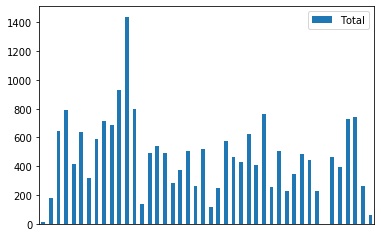

In [131]:
ax = totals.plot.bar(x='Neighborhood', y='Total', rot=90)
x_axis = ax.axes.get_xaxis()
x_axis.set_visible(False)